# Overview

## Data Preprocessing

### Only the images provided with the course were used. The right and left camera images were also used and the angles were offset by 0.20. subtracted from right, added to left.
### 90% of the data is used for training, 10% for validation. Testing is done on the simulator
### Since a majority of the images and steering angles were from driving in a straight line, the data needed to be preprocessed.
### This was first done by randomly dropping an image half the time where the angle was less 0.08 or greater than -0.08 as a lot of straight line data would cause overfitting. 
### Secondly, the data was augmented to generate more data and reduce overfitting. Each time an image was picked it was randomly flipped half of the time. Afterwards the images were randomly translated and steering angle adjusted to mimic as if the car was recovering from multiple places on the road. Using this technique an unlimited amount of data can be generated and there is no problem of overfitting. (Later, there are no dropout layers used for this reason.) 



## Designing Model Architecture and Architecture Characteristics

### I first started with a simple network with only a few fully connected layers to make sure the data was being processed properly. During evaluation, the model, although navigated the road a little bit, failed to perform. This led me to believe that the model needed more complexity. I tried a few different architectures with adding convulation layers to increase the complexity. These ones performed a little better and gave me the idea that i was heading in the right direction. Instead of reinventing the wheel i searched for networks that had been tried and tested for my purposes. The two most common ones i came across are the Nvidia model and a model from comma.ai. To understand the Nvidia model better I went to their research paper that details the model. 

### I adjusted the image to match the size the authors of the paper used (66,200) since the architecture had been proven to work with images of that input size. 

### I tried to customize the model to better fit my requirements. For this reason I had to make a few changes:

### A common implementation of the Nvidia model has relu activations in fully connected layers. After much experiementation, the model seemed to drive car better when there were no activation layers between the fully connected layers. 

### When using dropout layers, the model didn't seem to learn to navigate special areas like the opening after the bridge on the right. Since the data generator always generates new data there doesn't seem to be an overfitting problem and thus dropout layers were eventually dropped. 

### In short, using my own model first of minimal fully-connected layers and then adding convulation layers led me to believe that my direction is correct. For this reason I chose the Nividia model and customized it to work for my data.

### The size and type of layers are as shown in the image below, which is from the original paper.

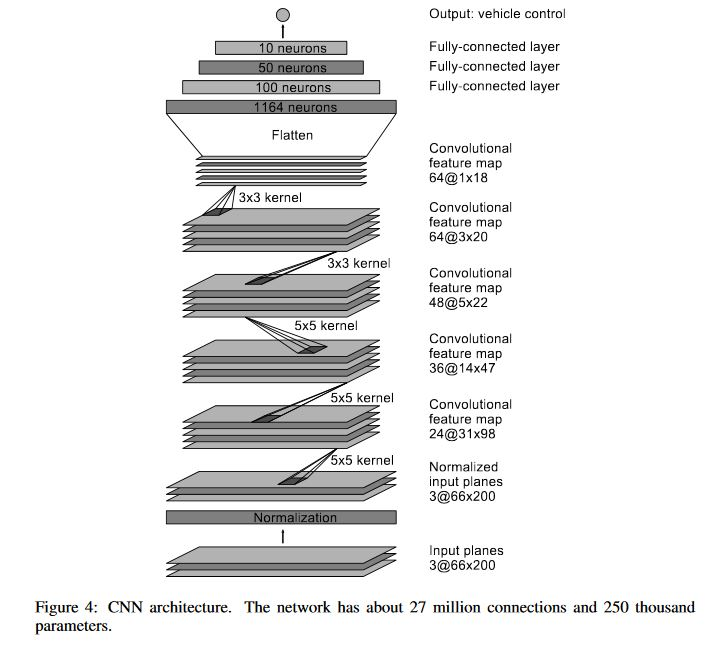

In [202]:
from IPython.display import Image
Image(filename='Network Image.JPG')
#This image is from Nvidia Paper.

## Model Training (including hyperparameter tuning)

### After a considerable amount of effort it was determined the running the model for more than one epoch would lead to overfitting. I tried reducing the batch size to increase the number of epochs but those results didn't compare with results from a single epoch. This was also tried in combination with reducing the learning rate even further but that didn't help either

### Learning Rate: a rate of 0.00005 is used as a higher rate results in the optimizer getting stuck in a local minima and the car would go off road. This was determined after a lot of experimentation

## The current parameters of the model, learning rate, epochs, batch size, samples per epoch, removal of dropout layers, removal of activation layers from fully connected layers took a total of 50+ hours. Setting up data generation and augmentation took around another 20 hours. All of the training was done on AWS.

In [193]:
#code to run docker in windows powershell
#docker run -it --rm -p 8888:8888 -p 4567:4567 -v ${pwd}:/src udacity/carnd-term1-starter-kit

In [1]:
#!pip install opencv-python

In [198]:
import cv2, math
import os, pandas as pd
import numpy as np
pd.options.display.max_rows = 5
from sklearn.utils import shuffle


import os
import argparse
import json
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, ELU, Lambda
from keras.layers import Convolution2D, MaxPooling2D, SpatialDropout2D
from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline

In [196]:
#Idea of translation as augmentation from Udacity Student Vivek
def translate_image(image,steer,trans_range):
    # Translation
    x_translate = trans_range*np.random.uniform()-trans_range/2
    y_translate = 40*np.random.uniform()-40/2
    
    Translation_Matrix = np.float32([[1,0,x_translate],[0,1,y_translate]])
    new_image = cv2.warpAffine(image,Translation_Matrix,(320,160))
    
    new_angle = steer + x_translate/trans_range*2*.2
  
    return new_image,new_angle

In [5]:
#function to adjust angles of left and right images
def fix_angle(filee, steeringBasedOnIndex):
    angle = steeringBasedOnIndex.ix[filee]['steering']#.values
    camera = (filee.split('_')[0][4:])

    if camera == 'right':
        angle = angle - shift_by
    if camera == 'left':
        angle = angle + shift_by
   
    return angle

In [6]:
# This generator virtually generates unlimited new data because of severe augmentation
def data_for_generator(fileNames, steeringBasedOnIndex , batch_size):
    while True:
        X_train =[]    
        angles = []
        for _ in range(batch_size):
            
            keep_image = 0
            # the while loop is used to randomly drop half of all the images where steering angle is less than 0.08
            while keep_image ==0:
                filee = np.random.choice(fileNames)
                
                angle = fix_angle(filee, steeringBasedOnIndex)
                
                if abs(angle) < 0.08:
                    if np.random.uniform() >= 0.5:
                        keep_image = 1
                else :
                    keep_image = 1
                
            image = cv2.imread('data/'+filee)
            
            #for data augmentation
            #randomly transform the images so the car can learn the recovery from different places on the road
            image,angle = translate_image(image,angle,100)
            
            # Randomly half of the images will be flipped
            flip = np.random.randint(2) #1/2 chance of flip
            if flip==0:
                image = cv2.flip(image,1)
                angle = -angle

            image = X_train.append(image)
            angles.append(angle)
        
        yield (np.array(X_train),np.array(angles))

In [7]:
#Parsing the csv to make the steering angles available
shift_by = 0.20
fileWithName = pd.read_csv('data/driving_log.csv')

center = fileWithName[['center','steering']]
right = fileWithName[['right','steering']]
left = fileWithName[['left','steering']]


steeringBasedOnIndex = \
    center.set_index('center').append(\
    left.set_index('left')).append(\
    right.set_index('right'))      
    
steeringBasedOnIndex.index = steeringBasedOnIndex.index.str.lstrip().str.rstrip()

In [8]:
#creating a list of all files and randomly shuffle them
all_files = shuffle(os.listdir('data/IMG/'),random_state = 258)
all_files = ['IMG/'+vals for vals in all_files]
#Use 90% data for training and 10 for validation
validation_split = int(len(all_files)*(0.90))
train_files = all_files[:validation_split]
validation_files = all_files[validation_split:]

(-1, 1)

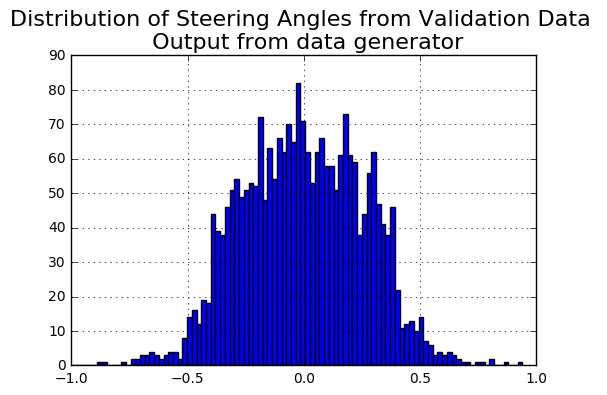

In [201]:
# This figure shows us how the data is generated once it comes out through the data generator. Original data would have 3 high 
#spikes at 0, -0.2 and 0.2, for straight driving images.As a result of augmentation we now have data that looks more normal,
# as can be see in the figure below
plt.figure()
pd.DataFrame((next(data_for_generator(validation_files, steeringBasedOnIndex,len(validation_files)))[1]))[0].hist(bins = 100)
plt.title('Distribution of Steering Angles from Validation Data \n Output from data generator', fontsize = 16)
plt.xlim(-1, 1)

In [9]:
print (len(validation_files))

2411

In [194]:
#function to save a model
def saveModel(model, num):
    json_string = model.to_json()
    with open('model'+num+'.json', 'w') as jfile:
      jfile.write(json_string)
    jfile.close()

    model.save_weights('model'+num+'.h5')

In [189]:
#Using Nvidia Model
model = Sequential()

#p2 = 0.2
#remove the top 22 pixel because of sky
model.add(Cropping2D(cropping=((22, 0), (0, 0)), input_shape=(160, 320, 3)))

#crop the image to match specifications of the Nvidia model
def resize(image):
    import tensorflow as tf
    return tf.image.resize_images(image, (66, 200)) 

model.add(Lambda(resize))

model.add(Lambda(lambda x: x/255.0 - 0.5))

model.add(Convolution2D(24, 5, 5, activation='relu', border_mode='valid', subsample=(2,2)))
#model.add(SpatialDropout2D(p1))
#model.add(Dropout(p2))
#model.add(Dropout(p2))

model.add(Convolution2D(36, 5, 5, activation='relu', border_mode='valid', subsample=(2,2)))
#model.add(SpatialDropout2D(p1))

model.add(Convolution2D(48, 5, 5, activation='relu', border_mode='valid', subsample=(2,2)))
#model.add(SpatialDropout2D(p1))
#model.add(Dropout(p2))

model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='valid', subsample=(1,1)))
#model.add(SpatialDropout2D(p1))

model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='valid', subsample=(1,1)))
#model.add(SpatialDropout2D(p1))
#model.add(Dropout(p2))
#model.add(Dropout(p2))

model.add(Flatten())

model.add(Dense(100))
#model.add(Dropout(p2))

model.add(Dense(50))
#model.add(Dropout(p2))

model.add(Dense(10))
#model.add(Dropout(p2))

model.add(Dense(1))

model.compile(optimizer=Adam(lr=0.00005), loss='mse')

#model.summary()


In [190]:
#1 Epochs used, more epochs lead to overfitting on certain areas and the car leaves the track
model.fit_generator(data_for_generator(train_files, steeringBasedOnIndex, 128),\
        samples_per_epoch=20480, nb_epoch=1,\
        validation_data=data_for_generator(validation_files, steeringBasedOnIndex,512) \
        ,nb_val_samples=len(validation_files))

Epoch 1/1
20480/20480 [==============================] - 139s - loss: 0.0365 - val_loss: 0.0280


In [192]:
saveModel(model, '')
